##### Day 2 agenda:
* more detailed understanding of the work flow
* further short and fun simulations
* grid convergence
* transport equations
* detailed scientific visualization of results

We will start with some common CFD topics. 

##### Grid Convergence
<u>Topics: setFields, fvSchemes, fvSolution, physicalProperties, sample, controlDict</u>

We take the example at /opt/openfoam10/tutorials/compressible/rhoPimpleFoam/laminar/shockTube/.
Make three case of it, for 100, 1000 and 10000 mesh.
For 10000 mesh, we need to adjust delta to 1e-6 to keep the CFL number below 1.

A shock wave is treated as a discontinuity where entropy increases abruptly as the shock passes. Here in the middle we introduce a change in pressure 
and temperature and we will observe how it spreads. 

We will use sonicFoam, the official description is,
" Transient solver for trans-sonic/ supersonic, laminar or turbulent flow of a compressible gas "
=> Compressible
=> Transient
=> Laminar and turbulent
=> single phase
=> non isothermal

sonicFoam and related functionality are merged into rphoPimpleFoam 
https://github.com/OpenFOAM/OpenFOAM-dev/commit/3341f925108a759f58f06ce2fd865321af6dd6ca


<u>setFieldDict:</u> It allows us to set values on a selected set of cells/ patch faces via a dictionary. We write setFields in the command line to generate the value.

sonicFoam cmd is depreciated. Please use rhoPimpleFoam with "transonic yes" in fvSolution
** Important: blockMesh cmd to generate the mesh -> setDicts to generate default value -> solver to run the simulation.

The geometry for three mesh configuaration with the discontinutiy looks like this,
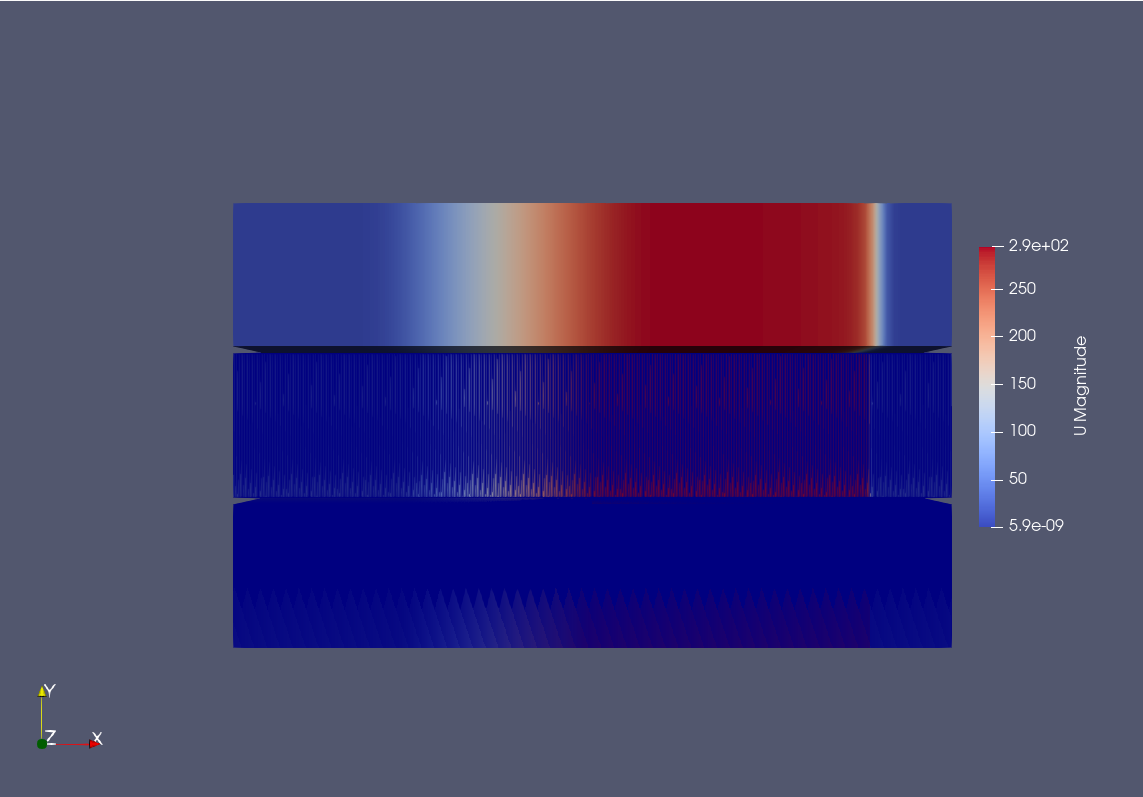

It is clear that the discontinutiy with 100 mesh is unrealistic and we need more mesh to get the accurate result.

This is how the graph looks like,
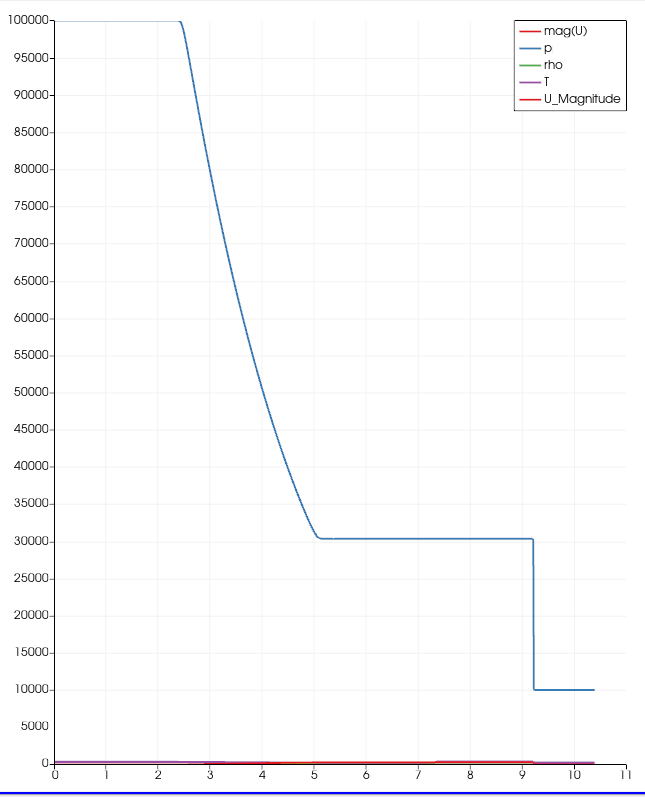

We can use the file system/sample to export line graph data. First we will calculate mag(u)
postProcess -func "mag(u)" ( for openFoam 10)
postProcess -func sample 

We do this for all three cases and we make a graph for the value at 0.007


   -4.995  348.432   5.87529e-09    100000
0  -4.985  348.432  5.875290e-09  100000.0
1  -4.975  348.432  5.875290e-09  100000.0
2  -4.965  348.432  5.875290e-09  100000.0
3  -4.955  348.432  5.875290e-09  100000.0
4  -4.945  348.432  6.912570e-09  100000.0
(999, 4)


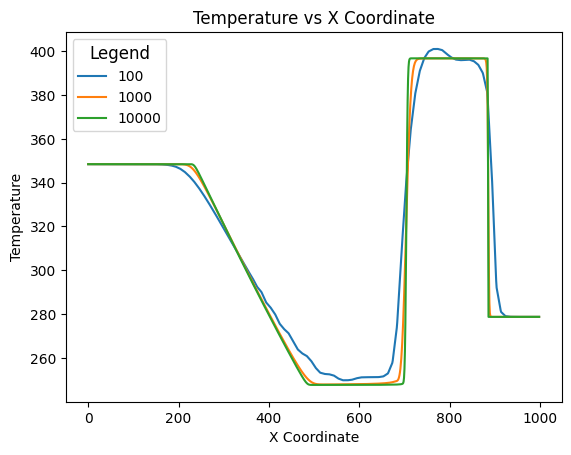

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

shocTube_100 = pd.read_csv("OpenFoamCode/shockTube_100/postProcessing/sample/0.007/data.xy", delim_whitespace=True, comment='#')
shocTube_1000 = pd.read_csv("OpenFoamCode/shockTube_1000/postProcessing/sample/0.007/data.xy", delim_whitespace=True, comment='#')
shocTube_10000 = pd.read_csv("OpenFoamCode/shockTube_10000/postProcessing/sample/0.007/data.xy", delim_whitespace=True, comment='#')

# 4 column of data, x coordinate, temperature, vel magnitude, pressure
print(shocTube_100.head())
print(shocTube_100.shape)

# Plotting the lines
plt.plot(shocTube_100.iloc[:, 1], label='100')
plt.plot(shocTube_1000.iloc[:, 1], label='1000')
plt.plot(shocTube_10000.iloc[:, 1], label='10000')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Temperature')
plt.title('Temperature vs X Coordinate')

# Customizing legend
plt.legend(title='Legend', title_fontsize='12', loc='upper left')

# Show the plot
plt.show()

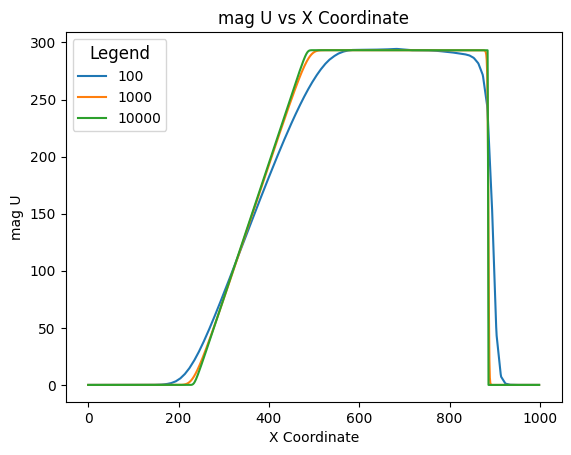

In [13]:
# Plotting the lines
plt.plot(shocTube_100.iloc[:, 2], label='100')
plt.plot(shocTube_1000.iloc[:, 2], label='1000')
plt.plot(shocTube_10000.iloc[:, 2], label='10000')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('mag U')
plt.title('mag U vs X Coordinate')

# Customizing legend
plt.legend(title='Legend', title_fontsize='12', loc='upper left')

# Show the plot
plt.show()

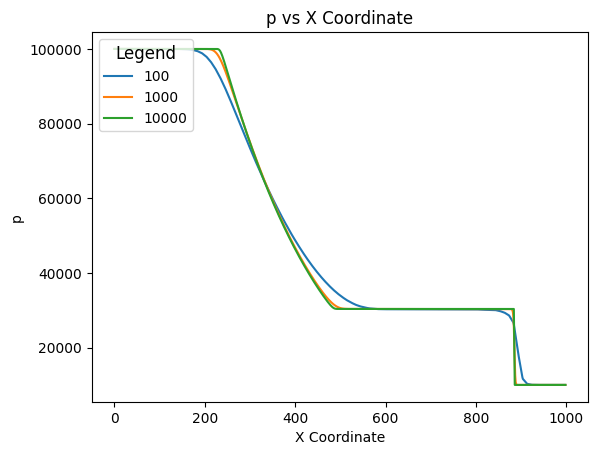

In [14]:
# Plotting the lines
plt.plot(shocTube_100.iloc[:, 3], label='100')
plt.plot(shocTube_1000.iloc[:, 3], label='1000')
plt.plot(shocTube_10000.iloc[:, 3], label='10000')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('p')
plt.title('p vs X Coordinate')

# Customizing legend
plt.legend(title='Legend', title_fontsize='12', loc='upper left')

# Show the plot
plt.show()

##### Transport Equation

We will discuss the most basic and most general equation. 
* the solver
* case setup 
* transport phenomena like convection and diffusion
* influence of constants
* simulation of scalar transport
* post processing

Here we will setup a case from scratch. We will use scalarTransportFoam.  

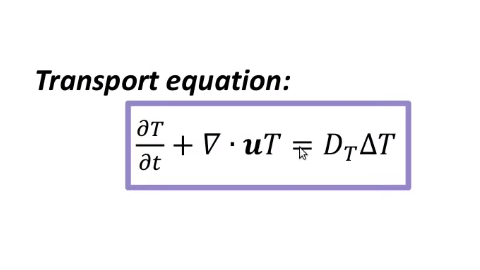

=> 2nd term in convection
=> lhs is diffusion
=> T is passive scalar

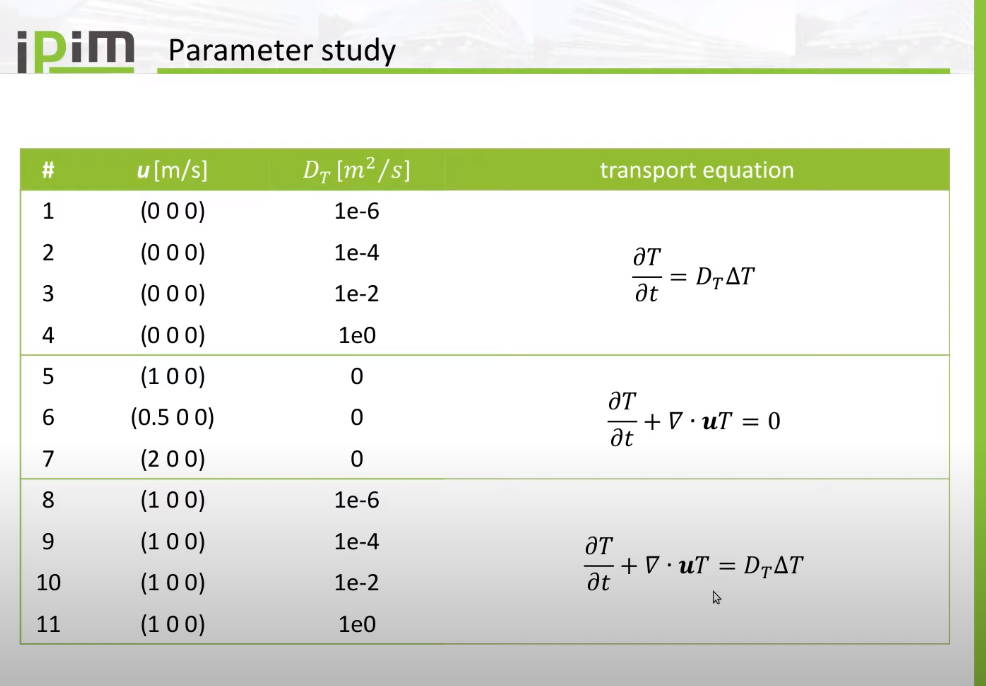

We will do study parameter study. First we see we have pure diffusion equation because of u being 0. 
This is important because in Momentum equations we also have convection and diffusion. 

For our case, we need to combine two tutorial. They are,
basic/scalarTransportFoam/pitzDaily
compressible/compressible/rhoPimpleFoam/laminar/shockTube

The pitzDaily example has T and U, shockTube has magU, p additionally. 
Also inside system folder, shockTube has more folders. 

We copy the shockTube folder initially and modify to fulfill our need.

We delete the fvSchemes fvSolution and copy it from pitzDaily

Now we have a case that is suitable for our case.

Now we copy the base file 11 times as we have 11 case.

Use the above table to set up 11 case. 

I am facing a problem in paraview, basically there is no T to visualize. 

I will continue this later.



##### Taylor Couette flow

This tutorial will simulate part of a classic experiment by G. I. Taylor published in 1923 titled, "Stability of a Viscous Liquid contained between
Two Rotating Cylinders". 

In a closed geometry interecting secondary flow patterns evolve in the gap between concentric, rotating cylinders.

We run the simulation with simpleFoam and check the result in paraview. 

$ . ~/OpenFOAM/OpenFOAM-v1812/etc/bashrc
$ cd taylor_couette
$ simpleFoam > log &
$ tail -f log

We have a log file with the simulation info. 

$ foamLog log //this does some data processing
$ wmUnset // unset all the global variable
$ cd logs
$ gnuplot // we are using default app to create plot
gnuplot> plot ’UzFinalRes_0’ with lines // creating plots

$ postProcess -func vorticity // we can use this functionality to calculate fields

We can use system/decomposeParDict to paralleize our simulation. Here we are using an algorithm called hierarchical.
Our configuration says that split up the geomertry in 8 parts, 2 in x-direction, 2 in y-direction and
2 in z-direction.  

$ decomposePar
$ mpirun -np 4 simpleFoam -parallel > log.parallel &
$ foamLog log.parallel
$ wmUnset
$ gnuplot
gnuplot> plot ’UzFinalRes_0’ with lines

With these commands, we can run the mpi and OpenFoam together. 

TODO: Exercise


